In [ ]:
# default_exp model
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# Model

> In this notebook you create and test a Python class to hold your machine learning model.

***input***: toy dataset from data-notebook

***output***: python module containing ML model class 

***description:***

In this notebook you hypothetize, explain and explore machine learning models to solve your problem.

Then, you should encapsulate the model inside a Python class to be exported into `your_repository/your_module/model.py`,
so that it can be evaluated in the loss notebook, and intergrated with your target application.
Repository name and module name are the same by default.
You should also unit test the classes created in this notebook with the toy data created in data notebook.

You should probably have a person in your team familiar with object oriented programming with python and unit testing, but if not, don't worry.
If you can explore by scripting in the cells and create a draft of the properties and functions you want to have, and that's a great start.
Then, any Python developer can easily build the model class for you.
However, we encourage you to learn more on [object oriented programming with Python](https://realpython.com/python3-object-oriented-programming/)
and [getting started with unit testing in Python](https://realpython.com/python-testing/).
You can also follow the example here to create your own simple machine learning Python class.

This notebook contains an example ML model for classifying the heart disease dataset with logistic regression.

The example is split into a base class and a subclass for demonstrating class inheritance of Python.
You can probably just write one class that contains all the attributes and functions you need, without inheriting anything.
However, alternative implementations of a model might be implemented in separate subclasses, for example.
You can also define multiple classes, for example one for ML model and another for optimization.
If the methods are complicated or you are comparing multiple methods that don't share common functions, 
you can also separate models or subclasses to different notebooks similar to this.
Adjust the running number, name, header and top cell `#default_exp module_name` of the notebooks accordingly.

Remember to add `# export` to top of all cells containing functions or classes that you have defined and want to use outside this notebook.



## Import relevant modules

In [ ]:
# export
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    train_test_split,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
# import custom modules

# plot functions from data notebook
from ml_project_template.data import plot_trellis, plot_histogram

## Define notebook parameters

Remember, only simple assignments here!

In [ ]:
# Parameters

# this cell is tagged with 'parameters'
seed = 0
toy_data_filename = "data/preprocessed_data/dataset_toy_switzerland_cleveland.csv"

Make immediate derivations from the parameters:

In [ ]:
np.random.seed(seed)

## Import toy data for testing

In [ ]:
toy_df = pd.read_csv(toy_data_filename, index_col=0)
toy_df.head()

,x1age,x4trestbps,x8thalach,x10oldpeak,y1num
0,53.0,142.0,111.0,0.0,0
1,56.0,200.0,133.0,4.0,1
2,62.0,140.0,143.0,0.0,1
3,53.0,160.0,122.0,0.0,1
4,54.0,160.0,163.0,0.0,0


> Note, that depending on your choice of file format and your variables, you might have to redefine data types once you load data! 

## Explain the math behind

Give a short explanation of how the algorithms work that you are planning to use.

For industrial use, you can keep this light and simple: you can provide links to external sources for further reading.

For research, you might want to dig deeper - this is your core documentation, after all!

You can use $\LaTeX$ notation to write math symbols and equations:

$$
Pr(Y_i=1|X_i) = {\frac{exp(\beta_0 + \beta_1X_i + \dots + \beta_nX_n)}{1 + exp (\beta_0 + \beta_1X_i + \dots + \beta_nX_n)}}
$$

You can also draft algorithms:

    ALGORITHM
    input: X
    output: y

    while: condition
        do thing


## Begin with simple scripts before constructing the model class

This is the place where you can explore and play around with different machine learning operations.
Your goal is to plan and demonstrate the features and functions you want your machine learning class to have.
The good thing is, that you don't need to think about object oriented programming here.
Just assign variables and call functions. 

It's good to define at least the following steps:

1. Splitting data into training and testing data
2. Preprocess the data (scale, dimension reduction, convolutions etc.)
3. Define your model algorithm and fit it with toy data
4. Define your loss function - how do you evaluate your model?
5. Consider hyperparameter optimization
6. Try to pipe the previous steps



Let's begin by splitting our data to train and test data

In [ ]:
# split train and test data
X = toy_df.iloc[:, :-1]
y = toy_df.iloc[:, -1]

k = 5  # test size 1/k

# train_test_split does the job here

# stratify = y means, that both the testing and training dataset contain
# label values in same proportion as they are in the whole dataset
# it only works with categorical data, and might cause errors there
# if some category is rare

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / k, random_state=seed, stratify=y
)

In [ ]:
# create preprocessing steps, model and pipe

# preprocessing: let's rescale the data
scaler = StandardScaler()

# algorithm: logistic regression
lgr = LogisticRegression()

# pipe: let's join these two in a pipeline
# now the pipeline actually becomes our machine learning model:
# we can just call the pipe instead of first scaling data and then
# calling the algorithm functions separatedly
pipe = Pipeline([("scaler", scaler), ("estimator", lgr)])
# fit data
pipe.fit(
    X_train,
    y_train,
)
# get test score
print(pipe.score(X_test, y_test))

0.4


In [ ]:
# define loss

# let's use f1  for loss here
f1_score(y_test, pipe.predict(X_test))

0.5714285714285715

Then we optimize the model hyperparameters with cross validated grid search.
Notice that this is just an example: grid search is very ineffective and does not quarantee good optimization solutions for hyperparameters.
In real applications Bayesian optimization is usually a great solution.
You can skip optimization in the beginning and return to it in the later iterations of the project.
For example sklearn models usually have good default hyperparameters, and you may well get started with those.

In [ ]:
# create optimization pipe

## hyperparameters to be optimized (be consistent with the naming)
param_grid = {
    "estimator__C": np.logspace(-4, 4, 10),
}

# create cross validation for grid search
cv = StratifiedKFold(n_splits=k)

# create optimizer
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    return_train_score=True,
)

# fit optimizer
gs.fit(X_train, y_train)

# view results
print("Best Estimator: \n{}\n".format(gs.best_estimator_))
print("Best Parameters: \n{}\n".format(gs.best_params_))
print("Best Test Score: \n{}\n".format(gs.best_score_))
print(
    "Best Training Score: \n{}\n".format(
        gs.cv_results_["mean_train_score"][gs.best_index_]
    )
)
print("All Training Scores: \n{}\n".format(gs.cv_results_["mean_train_score"]))
print("All Test Scores: \n{}\n".format(gs.cv_results_["mean_test_score"]))

# set pipe hyperparameters to the optimized:
pipe.set_params(estimator__C=gs.best_params_["estimator__C"])

# fit pipe
pipe.fit(X_train, y_train)
print("Pipe test score with optimized hyperparams")
print(pipe.score(X_test, y_test))

Best Estimator: 
Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator', LogisticRegression(C=0.3593813663804626))])

Best Parameters: 
{'estimator__C': 0.3593813663804626}

Best Test Score: 
0.75

Best Training Score: 
0.8375

All Training Scores: 
[0.6    0.6    0.6    0.65   0.8375 0.8375 0.8375 0.8375 0.8375 0.8375]

All Test Scores: 
[0.6  0.6  0.6  0.55 0.75 0.75 0.65 0.65 0.65 0.65]

Pipe test score with optimized hyperparams
0.4


Ok, so we can fit a model to the data and it appears to do something (with the small test data we can not necessarily say if it's meaningful).

However, how would you take this script into production?
How would you scale it, or use it with completely different setup of data and parameters?
(well, this is a tiny example, so we could actually easily parameterize a script, but that's rarely the case in real world applications)

This is why we need to construct a model class, to hold all of the steps required in separate, tidy functions.
Then we can recreate the model and the steps with different data, without copy-pasting or manually editing all the tiny details.

Follow along the example - you'll see, that half the work was done in the scripting cells above!

## Define base class for your ML model

You will probably do just fine creating a one simple class that does not inherit anything.
You can then use this example base class as a template for your machine learning class. 
However, this is not always the case, and class inheritance is one of the most useful features of Python (and object oriented programming).
This is why we wanted to demonstrate a base class - subclass division.

Here we define the base class `MachineLearningModel` that holds some simple functions for handling data, that would be common for all subclasses.
If a function only contains a `pass`-statement, it will be defined in the subclass.

> **Note**: in this example the model instance contains the data. 
This is rarely applicable in practice if the data is large.
Instead, in most applications the model should be routed to query the data when needed, in a similar way that it would appear as if the model instance contained the data.  

In [ ]:
# export

# Define base class for our classifier
class MachineLearningModel:
    """
    Overly simplified example for a base class:

    data handling operations

    handle definitions of other functions
    """

    def __init__(self, X, y, n_splits=5, seed=0):
        self.n_splits = n_splits  # k-fold n_splits
        self.seed = seed  # random state

        self.set_data(X, y)  # init model data (see below)

    def set_data(self, X, y):
        """
        Set traing and evaluation data
        """
        self.X = X.copy()
        self.y = y.copy()

        # in addition we separate train and test data:
        self.__create_train_test_data()  # see below

        return self

    def get_data(self) -> (np.ndarray, np.ndarray):
        """
        Get training and evaluation data
        """
        return self.X.copy(), self.y.copy()

    def __create_train_test_data(self, n_splits=None, seed=None):
        """
        Create training and testing data
        """
        # you might want to control the seed:
        if seed is None:
            seed = self.seed

        # you might want to control the number of splits
        if n_splits is None:
            n_splits = self.n_splits

        # split train and test data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=(1 / n_splits), random_state=seed, stratify=self.y
        )

        return self

    def get_train_test_data(self):
        """
        Return X_train, X_test, y_train, y_test
        """
        return self.X_train, self.X_test, self.y_train, self.y_test

    def fit(self, X=None, y=None, **fit_params):
        """
        To be defined in the subclass
        """
        pass

    def predict(self, X):
        """
        To be defined in the subclass
        """
        pass

    def loss(self, X, y):
        """
        To be defined in the subclass
        """
        pass

    def get_train_loss(self):
        """
        To be defined in the subclass
        """
        pass

    def get_test_loss(self):
        """
        To be defined in the subclass
        """
        pass

    def optimize(self):
        """
        To be defined in the subclass
        """
        pass

    def get_params(self):
        """
        To be defined in the subclass
        """
        pass

## Unit test base class

Purpose of unit testing is to cover all possible excecution paths in code.
Unit testing helps developers to avoid and identify bugs in code.

To unit test the class, we want to try and call every function of it and execute every different possible execution path.
The proportion of possible paths covered is called the test coverage.
100% coverage is rarely possible,
but it would be good to try and test the functions with good and bad input,
and with possible limit values (min, max, zero, None, np.nan, empty list etc.).

However, a few simple tests are easier to maintain (and to actually get done in the first place) than exhaustive unit testing.
Don't worry about coverage too much!
A few well considered tests are better than having none.

At the moment, nbdev considers all cells that do not have `# export` tag as tests.
Unit tests can be defined with `assert` command - the nbdev git hooks run these commands when you push commits.
Cells with `# slow` -tag will be omitted for time savings.

The line after `assert` should have a `True` or non-zero value.
`False`, 0 or None object will raise an `AssertionError`. Note that `np.nan` does not raise the error.

This is handy because you can now keep all your tests in the same file (notebook) with the code and documentation.
The downside is, however, that at the moment there is no good solution for monitoring test coverage of notebook developed code. 
If test coverage measuring is required, one option would be to implement tests with  `pytest` or `unittest` and export the tests to separate test.py file.

Let's begin by introducing a couple of super simple unit test examples:


In [ ]:
# Example of a simple unit test
this_statement_is_true = True
assert this_statement_is_true

# Another example of simple unit test of a function
def return_three():
    return 3


# unit test return_tree
assert return_three() == 3

# Third example of simple unit testing of a simple class
class SimpleClass:
    """
    Simple class that stores an attribute and has a function to return it
    """

    def __init__(self, parameter):
        self.attribute = parameter

    def get_attribute(self):
        return self.attribute


# unit thest init (should return class instance)
assert SimpleClass("hello world!")
# unit test get_attribute (should return 'Hello world!')
assert SimpleClass("Hello world!").get_attribute() == "Hello world!"

If the assert commands run without an error, the tests pass.

Now, let's include some tests with our example ML base class:

In [ ]:
# test init
assert MachineLearningModel(X, y)

mlmodel = MachineLearningModel(X, y)

# test get_data
assert mlmodel.get_data()[0].shape == X.shape
assert mlmodel.get_data()[1][1] == y[1]

# test __create_test_train_data and get_train_test_data
assert np.ceil(
    10 * mlmodel.get_train_test_data()[-1].shape[0] / mlmodel.get_data()[1].shape[0]
) == np.ceil(10 / mlmodel.n_splits)

# test set_data (you should be able to change the model data completely)
assert (
    MachineLearningModel(X, y)  # create model as usual
    .set_data(X.iloc[range(X.shape[0] - 1, -1, -1)], y)  # reset data in reverse order
    .get_data()[0]  # get data
    .iloc[0, 0]
) == X.iloc[
    -1, 0
]  # first element is now reversed to last

## Define subclasses & functions

A subclass or child class inherits all attributes and functions of a parent class, but may also have additional functions defined.

Here we define an example of a subclass of `MachineLearningModel`, the `LogisticRegressionModel` which performs logistic regression:

In [ ]:
# export

# Create subclass
# now you see, that the subclass inherits data handling functions from the base class,
# and we do not need to redefine them (although we could if we wanted to!


class LogisticRegressionClassifier(MachineLearningModel):
    """
    Logistic regression classifier
    """

    def __init__(self, X, y, n_splits=5, seed=0):

        # we need to initialize the parent class with super.init:
        super(LogisticRegressionClassifier, self).__init__(
            X, y, n_splits=n_splits, seed=seed
        )

        # define preprocessing, algorithm and pipe
        self.scaler = StandardScaler()
        self.model = LogisticRegression()
        self.pipe = Pipeline([("scaler", self.scaler), ("estimator", self.model)])

        # cross validation for optimization
        self.cv = StratifiedKFold(n_splits=self.n_splits)

        # param grid for optimization
        self.param_grid = {
            "estimator__C": np.linspace(0.3, 1.7, 10)  # logspace(-4, 4, 10),
        }

        # define optimization method for optimizing the model
        self.optimization_pipe = GridSearchCV(
            estimator=self.pipe,
            param_grid=self.param_grid,
            scoring="accuracy",
            cv=self.cv,
            return_train_score=True,
        )

    def fit(self, X=None, y=None):
        """
        Train and evaluate model
        """
        if X is None or y is None:
            self.pipe.fit(self.X_train, self.y_train)
        else:  # reset data, recreate training and testing data and recursively call fit
            self.set_data(X, y).fit()

        return self

    def predict(self, X):
        """
        Get predicted value at X
        """
        return self.pipe.predict(X)

    def loss(self, X, y):
        """
        Return loss (model quality metric) [f1 score]

        Note that this may be a different metric than the one that the model optimizer is using (scoring method).
        For example for LogisticRegression the scoring method is mean accuracy,
        but we want to track f1-score for loss because it is better balanced.
        """

        return f1_score(y, self.predict(X))

    def get_train_loss(self):
        """
        Return loss for training data
        """
        return self.loss(self.X_train, self.y_train)

    def get_test_loss(self):
        """
        Return loss for testing data
        """
        return self.loss(self.X_test, self.y_test)

    def optimize(self):
        """
        Optimize model hyperparameters and fit the model with optimized parameters.

        This example is with GridSearchCV, but more efficient algorithms can be implemented in practice.
        """
        self.optimization_pipe.fit(self.X_train, self.y_train)
        self.pipe.set_params(
            estimator__C=self.optimization_pipe.best_params_["estimator__C"]
        )
        self.fit()
        return self

    def get_params(self):
        """
        Return parameters
        """
        return self.pipe.get_params()

## Unit test subclasses

In [ ]:
# test init
assert LogisticRegressionClassifier(X, y)
lgr_model = LogisticRegressionClassifier(X, y)

# test fit
try:  # fit should be called before predict or score
    lgr_model.predict([1, 1, 1, 1])  # so this will cause an error
except:  # but the except statement catches the error
    pass  # yes, you can also test what should not work!

# there are two ways we can call the fit function: with and without data
assert lgr_model.fit()
assert lgr_model.fit(X, y)

# test predict
assert lgr_model.predict(X[::1]).any()
# test loss
assert lgr_model.get_train_loss()
assert lgr_model.get_test_loss()

# test get_params
assert lgr_model.get_params()

In addition, we might observe that our model is very slow (this example is not).

Then, we could try to evaluate how much time each of the functions,
and even the contents of the functions take to identify the bottlenecks.
The theory of [order of functions](https://en.wikipedia.org/wiki/Big_O_notation) may also be useful.

However, this is something you should only do in the late stages of your project.
Remember, thinking time is what matters in data science!
Begin with overoptimizing things, and you'll never have results.

Anyway, you can easily time functions in notebooks with `%%timeit` [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html):


In [ ]:
# slow
%timeit -n 3 -r 4 LogisticRegressionClassifier(X, y)

1.29 ms ± 159 µs per loop (mean ± std. dev. of 4 runs, 3 loops each)


## Visualize model behaviour with toy data

Now, with the unit tests we can assume that our model does something right.
At least any of the functions do not crash with expected input.

As with the data preparation, the last step is to visualize the model performance.
With small sample data, we may not see anything interestin,
but sometimes already small number of datapoints can reveal interesting properties of the model when visualized.

You can also define functions for visualizing the model performance, and export them to the model module,
or include them directly as part of your machine learning model class if you see benefits from it.
Either way, it's better to test them too with the toy data before the real deal!


Quite often we would like to see how a model performs when the number of data is increased.
The two common questions are:

1. How much data is needed that the model is accurate?

2. How much data we can put in the model and still be able to run it with our resources?

Then, we might have to balance between these two.



So, for our example, let's loop through a range of data points, fit and time the model at each round

In [ ]:
import time  # library for checking time

lgr = LogisticRegressionClassifier(X, y)

# dataframe to save results
eval_df = pd.DataFrame()

for i in range(10, X.shape[0]):
    lgr.fit(X.iloc[:i], y.iloc[:i])

    begin = time.time()  # measure time before model is optimized
    lgr.optimize()
    end = time.time()  # measure time after optimization

    ret = pd.DataFrame(
        {
            "round": [i - 10],
            "n_obs": [lgr.get_data()[0].shape[0]],
            "train_loss": [lgr.get_train_loss()],
            "test_loss": [lgr.get_test_loss()],
            "optimized_C": [lgr.get_params()["estimator__C"]],
            "optimization_time": end - begin,  # time spent in optimization
        }
    )
    eval_df = pd.concat([eval_df, ret], axis=0, ignore_index=True)
eval_df.set_index("round", inplace=True)
eval_df.head()

/anaconda/envs/templateenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/anaconda/envs/templateenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/anaconda/envs/templateenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/anaconda/envs/templateenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only 

,n_obs,train_loss,test_loss,optimized_C,optimization_time
round,,,,,
0,10,0.769231,0.666667,0.300000,0.382582
1,11,0.769231,0.500000,0.300000,0.382841
2,12,0.800000,0.000000,0.300000,0.380336
3,13,0.769231,1.000000,0.611111,0.382097
4,14,0.833333,0.000000,0.455556,0.378349


As we can see, the stratification gives some warnings with such a small test set.

Now you can also visualize the results. Super simple example:

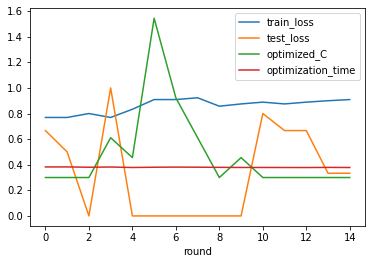

In [ ]:
# slow
_ = eval_df.drop("n_obs", axis=1).plot()
plt.show()

Remember that in you application you might be interested in completely different measures!

## Output of this notebook

The result of this notebook is a collection methods ready for evaluation with the real data.

You should export classes and functions to `model.py` with `# nbdev_build_lib` (workflows will do this automatically).

## You can move on to loss notebook!